In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Secret data generating mechanism that as the optimisation engineer you don't have access to. 
# However, to evaluate the final solution beyond the training objective 
# (which is quite likely close to zero for any training procedure due to huge number of parameters) 
# we need access to w_star. 

# You may feel free to use the variable data_dim. All other variables here are off limits. 

# Data description: 30 data points for 100 dimensional regression problem. 

data_dim = 100
num_data = 30
sparsity = 3
np.random.seed(100) 
w_temp = np.random.randn(sparsity)
indices = np.random.choice(data_dim, sparsity, replace=False)
w_star=np.zeros(data_dim)
w_star[indices]=w_temp

data_matrix = np.random.randn(num_data, data_dim)*0.5
labels = np.dot(data_matrix, w_star) + 0.0*np.random.randn(num_data)


global_A = np.dot(data_matrix.T, data_matrix) / num_data
global_b = np.dot(data_matrix.T,labels) / num_data
global_c = 0.5* np.dot(labels, labels) / num_data
global_w_star = np.array(w_star)

print('w_star=', global_w_star)
print('Non-zero coeffs=', np.where(np.abs(global_w_star)>1e-5))
eig_vals, eig_vecs = np.linalg.eig(global_A)
smoothness_coeff = np.real(np.max(eig_vals))
print('Smoothness coeff=', smoothness_coeff)




w_star= [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.1530358   0.          0.
  0.         -1.74976547  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.3426804   0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0. 

In [3]:

def get_value(w):
    A = global_A
    b = global_b
    return 0.5*np.dot(w, np.dot(A,w)) - np.dot(b,w) + global_c

def get_gradient(w):
    A = global_A
    b = global_b
    return np.dot(A,w)-b

    

# Question 1:

Assume you have oracle access to a regression error function (call it f) on some training data. Solve the LASSO optimisation problem, over some given l1 norm ball using the projected gradient descent.

1. Write the function for the l1 norm projection oracle, l2 norm projection oracle and the respective PGD steps.

2. Plot f(w_t) vs t for the PGD algorithm with l2 norm projection oracle. The step size is fixed to eta=0.01. Repeat the plots with different l2 norm constraints: 0.1, 0.5, 1, 2, 5 (on the same plot). 

3. Plot f(w_t) vs t for the PGD algorithm with l1 norm projection oracle. The step size is fixed to eta=0.01. Repeat the plots with different l1 norm constraints: 0.1, 0.5, 1, 2, 5 (on the same plot).

4. Let $w^1_\lambda$ be the result of running PGD with the l1 norm constraint of lambda for 500 iterations. Similarly let $w^2_\mu$ be the result of running PGD with the l2 norm constraint of mu for 500 iterations. Give two separate cells with each cell containing 2 plots as follows: 

    4a. In the first cell: $f(w^1_\lambda)$ vs $\lambda$ and $||w^1_\lambda - w^* ||$ vs $\lambda$.    
    4b. In the Second cell: $f(w^2_\mu)$ vs $\mu$ and $||w^2_\mu - w^* ||$ vs $\mu$. 
    
    Note 1: $w^*$ is the vector used in data generation. 
    Note 2: Using $w^*$ is illegal anywhere else. But it's okay here to just make a point.
    Note 3: The range of mu and lambda to plot may be taken to be 0.1 to 3.
    Note 4: We can take the norm above to simply be the difference in the set of non-zero components

5. Summarise and explain your findings in a markdown cell

In [4]:
# Question 1 part 1

def projection_oracle_l2(w, l2_norm):
    """Projects a given vector onto a ball (as defined by l2_norm) of given radius around the origin
    
    Args:
        w (ndarray): given vector to be projected 
        l2_norm (ndarray): radius of the l2_norm ball
    
    Returns:
        w_projected (ndarray): projected vector
    """
    norm_w = np.sqrt(np.dot(w,w))
    if norm_w <= l2_norm:
        w_projected = w
        
    else:
        w_hat = w/norm_w
        w_projected = w_hat*l2_norm
    
    return w_projected

def compute_l1_norm(x):
    """Function to compute the l1 norm of a given vector
    
    Args:
        x (ndarray): vector whose l1 norm is to be computed
    
    Returns:
        l1_norm (float): l1 norm of the given vector
    """
    
    x = np.array(x)
    l1_norm = np.sum(np.abs(x))
    
    return l1_norm

def vector_plus(x):
    """Function to retain positive values of a vector and set negative values to 0
    
    Args:
        x (ndarray): input vector
    
    Returns:
        x_plus (ndarray): output vector
    """
    x = np.array(x)
    mask = x>0
    x_plus = x*mask
    
    return x_plus


def projection_oracle_l1(w, l1_norm):
    """Projects a given vector onto a ball (as defined by l1_norm) of given radius around the origin
    
    Args:
        w (ndarray): given vector to be projected 
        l1_norm (ndarray): radius of the l1_norm ball about the origin
    
    Returns:
        w_projected (ndarray): projected vector
    """
    w = np.array(w)
    w_sign = 2*(w>0) - 1
    w_pos = np.abs(w)
    w_norm = compute_l1_norm(w)
    
    if w_norm <= l1_norm:
        w_projected = w
    else:
        # tolerance value in projection
        epsilon = 10**(-5)
        # original vector is outside l1 ball
        tau_low = 0
        
        # finding a tau high that pushes given vector into l1 ball
        tau_high = 1
        one_vector = np.ones(len(w))
        forced_vector = vector_plus(w_pos - tau_high*one_vector)
        while compute_l1_norm(forced_vector) > l1_norm:
            tau_high = 2*tau_high
            forced_vector = vector_plus(w_pos - tau_high*one_vector)
            
        tau = (tau_high + tau_low)/2
        w_projected = w_sign*vector_plus(w_pos - tau*one_vector) 
        norm_w_projected= compute_l1_norm(w_projected)
        
        while np.abs(norm_w_projected - l1_norm) > epsilon:
            # "projection" too far in, gotta reduce tau
            if norm_w_projected < l1_norm:
                tau_high = tau
            # "projection" is still too close to the original point
            elif norm_w_projected > l1_norm:
                tau_low = tau
            tau = (tau_high + tau_low)/2
            w_projected = w_sign*(vector_plus(w_pos - tau*one_vector))
            norm_w_projected = compute_l1_norm(w_projected)
    
    return w_projected

def PGD_step_l2(w, l2_norm, eta=0.1):
    """Performs one step of projected gradient descent for l2 norm
    
    Args:
        w (ndarray): iterate at the t-th iteration
        l2_norm (float): radius of the l2_norm ball onto which given vector must be projected
        eta (float): step size for PGD
    
    Returns:
        w_next_projected (ndarray): iterate at the t+1-th iteration
        
    """
    
    grad_w = get_gradient(w)
    
    # update
    w_next = w - eta*grad_w
    
    # projection
    w_next_projected = projection_oracle_l2(w_next, l2_norm)
    
    return w_next_projected

def PGD_step_l1(w, l1_norm, eta=0.1):
    """Performs one step of projected gradient descent for l1 norm
    
    Args:
        w (ndarray): iterate at the t-th iteration
        l1_norm (float): radius of the l1_norm ball onto which given vector must be projected
        eta (float): step size for PGD
    
    Returns:
        w_next_projected (ndarray): iterate at the t+1-th iteration
        
    """
    
    grad_w = get_gradient(w)
    
    # update
    w_next = w - eta*grad_w
    
    # projection
    w_next_projected = projection_oracle_l1(w_next, l1_norm)
    
    return w_next_projected
    

Text(0.5, 1.0, 'Loss vs Iteration for l2-norm ball PGD, with different l2 norm constraints')

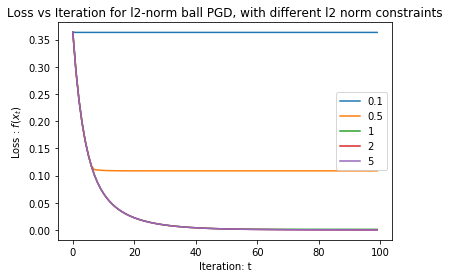

In [5]:
# Question 1 part 2

f_vals_all=[]
plt.figure()
norm_constraint_vals = [0.1, 0.5, 1, 2, 5]
for norm_constraint in norm_constraint_vals:
    f_vals=[]
    w=np.zeros(data_dim)

    for t in range(100):
        w = PGD_step_l2(w, norm_constraint)
        f_vals.append(get_value(w))
    f_vals_all.append(f_vals)
plt.plot(range(100),np.array(f_vals_all).T)
plt.legend(norm_constraint_vals)
plt.xlabel('Iteration: t')
plt.ylabel('Loss : $f(x_t)$')
plt.title('Loss vs Iteration for l2-norm ball PGD, with different l2 norm constraints')




Text(0.5, 1.0, 'Loss vs Iteration for l1-norm ball PGD, with different l1 norm constraints')

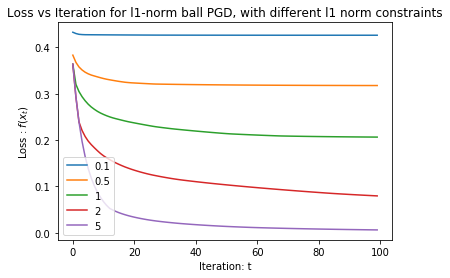

In [6]:
# Question 1 part 3

f_vals_all=[]
plt.figure()
norm_constraint_vals = [0.1, 0.5, 1, 2, 5]
for norm_constraint in norm_constraint_vals:
    f_vals=[]
    w=np.zeros(data_dim)
    for t in range(100):
        w = PGD_step_l1(w, norm_constraint)
        f_vals.append(get_value(w))
    f_vals_all.append(f_vals)
plt.plot(range(100),np.array(f_vals_all).T)
plt.legend(norm_constraint_vals)
plt.xlabel('Iteration: t')
plt.ylabel('Loss : $f(x_t)$')
plt.title('Loss vs Iteration for l1-norm ball PGD, with different l1 norm constraints')


Text(0.5, 1.0, 'L2 norm projected gradient descent')

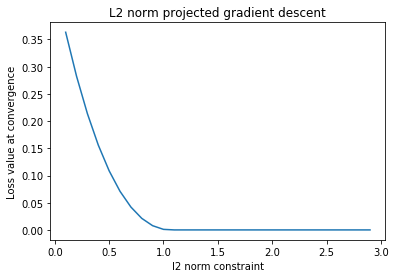

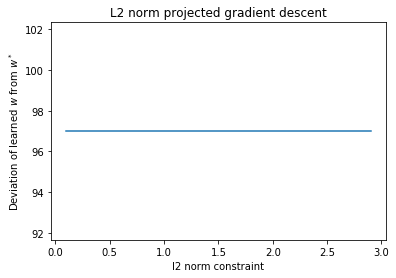

In [7]:
# Question 1 part 4a

norm_constraint_vals = np.arange(0.1,3,0.1)
loss_values=[]
deviation_from_truth=[]
for norm_constraint in norm_constraint_vals:
    w=np.zeros(data_dim)
    for t in range(100):
        w = PGD_step_l2(w, norm_constraint)
    loss_values.append(get_value(w))

    # One measure of deviation is to check the non-zero components that are 
    # different in w and w_star
    
    nonzero_w_star = set(np.where(np.abs(global_w_star)>1e-5)[0])
    nonzero_w = set(np.where(np.abs(w)>1e-5)[0])
    deviation_from_truth.append( len(nonzero_w.symmetric_difference(nonzero_w_star)) )
    
plt.figure()
plt.plot(norm_constraint_vals, loss_values)
plt.xlabel('l2 norm constraint')
plt.ylabel('Loss value at convergence')
plt.title('L2 norm projected gradient descent')

plt.figure()
plt.plot(norm_constraint_vals, deviation_from_truth)
plt.xlabel('l2 norm constraint')
plt.ylabel('Deviation of learned $w$ from $w^*$')
plt.title('L2 norm projected gradient descent')

Text(0.5, 1.0, 'L1 norm projected gradient descent')

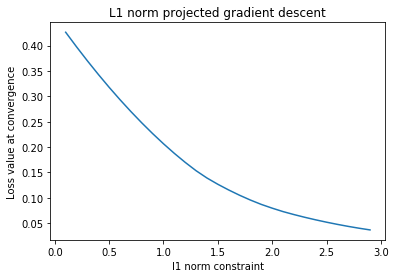

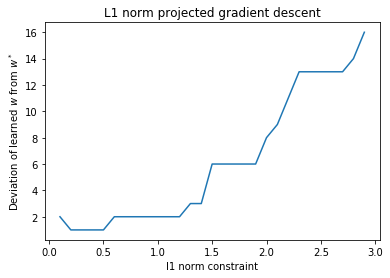

In [8]:
# Question 1 part 4b

norm_constraint_vals = np.arange(0.1,3,0.1)
loss_values=[]
deviation_from_truth=[]
for norm_constraint in norm_constraint_vals:
    w=np.zeros(data_dim)
    for t in range(100):
        w = PGD_step_l1(w, norm_constraint)
    loss_values.append(get_value(w))
    
    # One measure of deviation is to check the non-zero components that are 
    # different in w and w_star
    
    nonzero_w_star = set(np.where(np.abs(global_w_star)>1e-5)[0])
    nonzero_w = set(np.where(np.abs(w)>1e-5)[0])
    deviation_from_truth.append( len(nonzero_w.symmetric_difference(nonzero_w_star)) )
    
plt.figure()
plt.plot(norm_constraint_vals, loss_values)
plt.xlabel('l1 norm constraint')
plt.ylabel('Loss value at convergence')
plt.title('L1 norm projected gradient descent')

plt.figure()
plt.plot(norm_constraint_vals, deviation_from_truth)
plt.xlabel('l1 norm constraint')
plt.ylabel('Deviation of learned $w$ from $w^*$')
plt.title('L1 norm projected gradient descent')


### Question 1 Part 5:



# Question 2:

Assume you have oracle access to a regression error function (call it f) on some training data. Solve the LASSO optimisation problem, over some given l1 norm ball using the Frank-Wolfe method. 

1. Write the function for the l1 norm LMO, l2 norm LMO and the respective FW steps.

2. Plot f(w_t) vs t for the FW algorithm with l2 norm LMO. Repeat the plots with different l2 norm constraints: 0.1,0.5,1,2,5 (on the same plot). 

3. Plot f(w_t) vs t for the FW algorithm with l1 norm LMO. Repeat the plots with different l1 norm constraints: 0.1,0.5,1,2,5 (on the same plot). 

4. Let $w^1_\lambda$ be the result of running FW with the l1 norm constraint of lambda for 500 iterations. Similarly let $w^2_\mu$ be the result of running FW with the l2 norm constraint of mu for 500 iterations. Give two separate plots with each plot containing 2 curves as follows: 

    4a. In the first plot: $f(w^1_\lambda)$ vs $\lambda$ and $||w^1_\lambda - w^* ||$ vs $\lambda$.    
    4b. In the Second plot: $f(w^2_\mu)$ vs $\mu$ and $||w^2_\mu - w^* ||$ vs $\mu$. 
    
    Note 1: $w^*$ is the vector used in data generation. 
    Note 2: Using $w^*$ is illegal anywhere else. But it's okay here to just make a point.
    Note 3: The range of mu and lambda to plot may be taken to be 0.1 to 3.
    Note 4: We can take the norm above to simply be the difference in the set of non-zero components
    
5. Summarise and explain your findings on 2,3,4 above in a markdown cell

In [10]:
# Question 2 part 1


def LMO_l2(u, l2_norm):
    """Linear minimization oracle for l2 norm ball
    
    Function to find the vector x belonging to the l2 norm ball
    of radius l2_norm which minimizes u*x
    
    Args:
        u (ndarray): direction of minimization
        l2_norm (ndarray): radius of l2_norm ball
    
    Returns:
        x (ndarray): vector belonging to the l2_norm ball which
            minimizes u*x (dot product)
    """
    u_norm = np.sqrt(np.dot(u,u))
    x = l2_norm*(-1*u)/u_norm
    
    return x

def LMO_l1(u, l1_norm):
    """Linear minimization oracle for l1 norm ball
    
    Function to find the vector x belonging to the l1 norm ball
    of radius l1_norm which minimizes u*x. This amounts to testing 
    the vertices of the corner region of the l1 norm ball which is a 
    convex hull of hte vertex vectors.
    
    Args:
        u (ndarray): direction of minimization
        l1_norm (ndarray): radius of l1_norm ball
    
    Returns:
        x (ndarray): vector belonging to the l1_norm ball which
            minimizes u*x (dot product)
    """
    
    # vertices are simply +l1_norm*canonical_basis and -l1_norm*canonical_basis
    num_dim = len(u)
    vertices = l1_norm*np.concatenate((np.identity(num_dim), -1*np.identity(num_dim)), axis = 0)
    dot_products = np.dot(vertices, u)
    x = vertices[np.argmin(dot_products),:]
    
    return x
    
def FW_step_l2(w, l2_norm, gamma):
    """Function to perform one iteration of Frank-Wolfe for l2 norm ball constraint
    
    Args:
        w (ndarray): iterate at the t-th iteration
        l2_norm (float): radius of the l2_norm ball
        gamma (float): parameter of the FW update
        
    Returns:
        w_next (ndarray): iterate at the t+1-th iteration
        
    """
    
    grad_w = get_gradient(w)
    y_t = LMO_l2(grad_w,l2_norm)
    
    w_next = gamma*y_t + (1 - gamma)*w
    
    return w_next
    

def FW_step_l1(w, l1_norm, gamma):
    """Function to perform one iteration of Frank-Wolfe for l1 norm ball constraint
    
    Args:
        w (ndarray): iterate at the t-th iteration
        l1_norm (float): radius of the l1_norm ball
        gamma (float): parameter of the FW update
        
    Returns:
        w_next (ndarray): iterate at the t+1-th iteration
        
    """
    
    grad_w = get_gradient(w)
    y_t = LMO_l1(grad_w,l1_norm)
    
    w_next = gamma*y_t + (1 - gamma)*w
    
    return w_next
    


Text(0.5, 1.0, 'Loss vs Iteration for l2-norm ball PGD, with different l2 norm constraints')

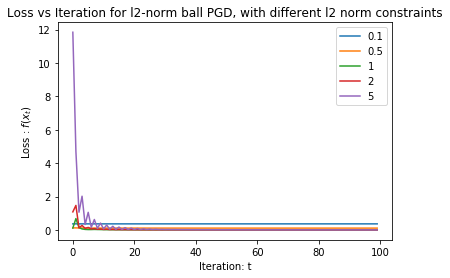

In [18]:
# Question 2 part 2

f_vals_all=[]
plt.figure()
norm_constraint_vals = [0.1, 0.5, 1, 2, 5]
for norm_constraint in norm_constraint_vals:
    f_vals=[]
    w=np.zeros(data_dim)

    for t in range(100):
        w = FW_step_l2(w, norm_constraint, gamma=2./(t+2))
        f_vals.append(get_value(w))
    f_vals_all.append(f_vals)
plt.plot(range(100),np.array(f_vals_all).T)
plt.legend(norm_constraint_vals)
plt.xlabel('Iteration: t')
plt.ylabel('Loss : $f(x_t)$')
plt.title('Loss vs Iteration for l2-norm ball PGD, with different l2 norm constraints')




Text(0.5, 1.0, 'Loss vs Iteration for l1-norm ball PGD, with different l1 norm constraints')

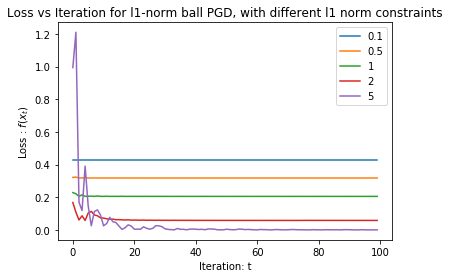

In [25]:
# Question 2 part 3

f_vals_all=[]
plt.figure()
norm_constraint_vals = [0.1, 0.5, 1, 2, 5]

# for value in list: does this not iterate through elements randomly
for norm_constraint in norm_constraint_vals:
#     print(norm_constraint)
    f_vals=[]
    w=np.zeros(data_dim)
    for t in range(100):
        w = FW_step_l1(w, norm_constraint, gamma=2./(t+2))
        f_vals.append(get_value(w))
    f_vals_all.append(f_vals)
plt.plot(range(100),np.array(f_vals_all).T)
plt.legend(norm_constraint_vals)
plt.xlabel('Iteration: t')
plt.ylabel('Loss : $f(x_t)$')
plt.title('Loss vs Iteration for l1-norm ball PGD, with different l1 norm constraints')

Text(0.5, 1.0, 'L2 norm projected gradient descent')

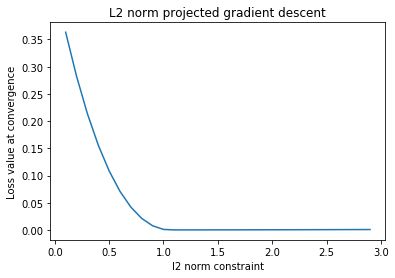

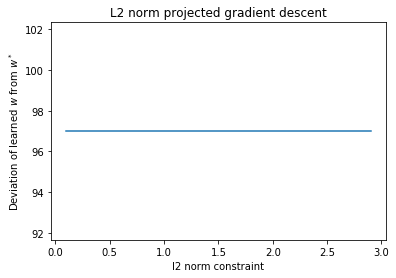

In [26]:
# Question 2 part 4a


norm_constraint_vals = np.arange(0.1,3,0.1)
loss_values=[]
deviation_from_truth=[]
for norm_constraint in norm_constraint_vals:
    w=np.zeros(data_dim)
    for t in range(100):
        w = FW_step_l2(w, norm_constraint, gamma=2./(t+2))
    loss_values.append(get_value(w))

    # One measure of deviation is to check the non-zero components that are 
    # different in w and w_star
    
    nonzero_w_star = set(np.where(np.abs(global_w_star)>1e-5)[0])
    nonzero_w = set(np.where(np.abs(w)>1e-5)[0])
    deviation_from_truth.append( len(nonzero_w.symmetric_difference(nonzero_w_star)) )
    
plt.figure()
plt.plot(norm_constraint_vals, loss_values)
plt.xlabel('l2 norm constraint')
plt.ylabel('Loss value at convergence')
plt.title('L2 norm projected gradient descent')

plt.figure()
plt.plot(norm_constraint_vals, deviation_from_truth)
plt.xlabel('l2 norm constraint')
plt.ylabel('Deviation of learned $w$ from $w^*$')
plt.title('L2 norm projected gradient descent')

Text(0.5, 1.0, 'L1 norm projected gradient descent')

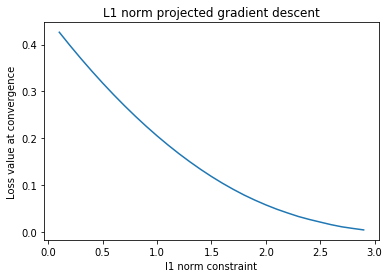

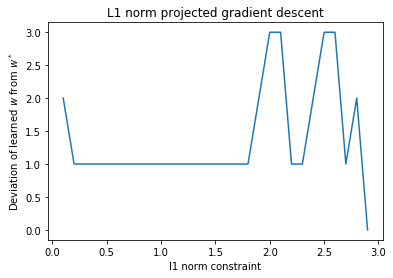

In [29]:
# Question 2 part 4b


norm_constraint_vals = np.arange(0.1,3,0.1)
loss_values=[]
deviation_from_truth=[]
for norm_constraint in norm_constraint_vals:
    w=np.zeros(data_dim)
    for t in range(100):
        w = FW_step_l1(w, norm_constraint, gamma=2./(t+2))
    loss_values.append(get_value(w))
    
    # One measure of deviation is to check the non-zero components that are 
    # different in w and w_star
    
    nonzero_w_star = set(np.where(np.abs(global_w_star)>1e-5)[0])
    nonzero_w = set(np.where(np.abs(w)>1e-5)[0])
    deviation_from_truth.append( len(nonzero_w.symmetric_difference(nonzero_w_star)) )
    
plt.figure()
plt.plot(norm_constraint_vals, loss_values)
plt.xlabel('l1 norm constraint')
plt.ylabel('Loss value at convergence')
plt.title('L1 norm projected gradient descent')

plt.figure()
plt.plot(norm_constraint_vals, deviation_from_truth)
plt.xlabel('l1 norm constraint')
plt.ylabel('Deviation of learned $w$ from $w^*$')
plt.title('L1 norm projected gradient descent')


### Question 2 part 5